# Climat‑Paris — Notebook d'analyse


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import calendar

## Graphique - jour de canicule et de gel (Par saison)

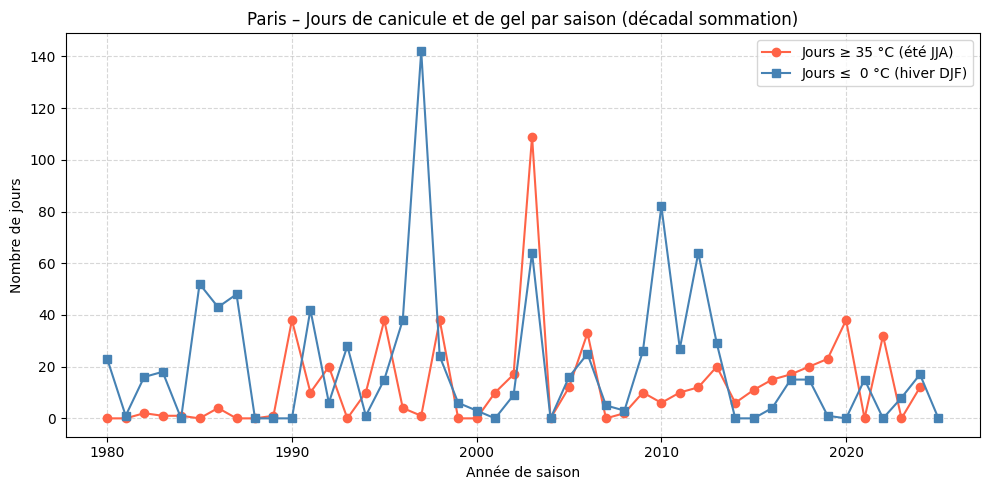

In [37]:
# ======================================================================
CSV = Path("DECADQ_75_1980-2024_CLEAN_FULL.csv")


df = pd.read_csv(CSV, sep=";", low_memory=False)

# year et month
df["AAAAMM"] = pd.to_numeric(df["AAAAMM"], errors="coerce")
df["year"]   = (df["AAAAMM"] // 100).astype(int)
df["month"]  = pd.to_numeric(df["month"], errors="coerce").astype(int)

# Convertir les colonnes de température en valeurs numériques
df["NBJTX35"] = pd.to_numeric(df["NBJTX35"], errors="coerce")  # jours ≥35°C par décade
df["NBJTX0"]  = pd.to_numeric(df["NBJTX0"],  errors="coerce")  # jours ≤ 0°C par décade

# saisons (JJA/DJF) et ajuste l'année d'hiver
def assign_season(row):
    m, y = row["month"], row["year"]
    if m in (6, 7, 8):
        return pd.Series({"season": "JJA", "season_year": y})
    if m in (12, 1, 2):
        # Décembre rattaché à l'hiver de l'année suivante
        return pd.Series({"season": "DJF", "season_year": y + (1 if m == 12 else 0)})
    return pd.Series({"season": None, "season_year": None})

df[["season", "season_year"]] = df.apply(assign_season, axis=1)

# Somme des jours canicule et gel par saison
summer = df[df["season"] == "JJA"].groupby("season_year")["NBJTX35"].sum()
winter = df[df["season"] == "DJF"].groupby("season_year")["NBJTX0"].sum()

# Trace les jours de canicule et de gel par saison
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(summer.index, summer.values, "-o", color="tomato", label="Jours ≥ 35 °C (été JJA)")
ax.plot(winter.index, winter.values, "-s", color="steelblue", label="Jours ≤  0 °C (hiver DJF)")
ax.set_title("Paris – Jours de canicule et de gel par saison (décadal sommation)")
ax.set_xlabel("Année de saison")
ax.set_ylabel("Nombre de jours")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

## Heatmap des anomalies saisonnieres 

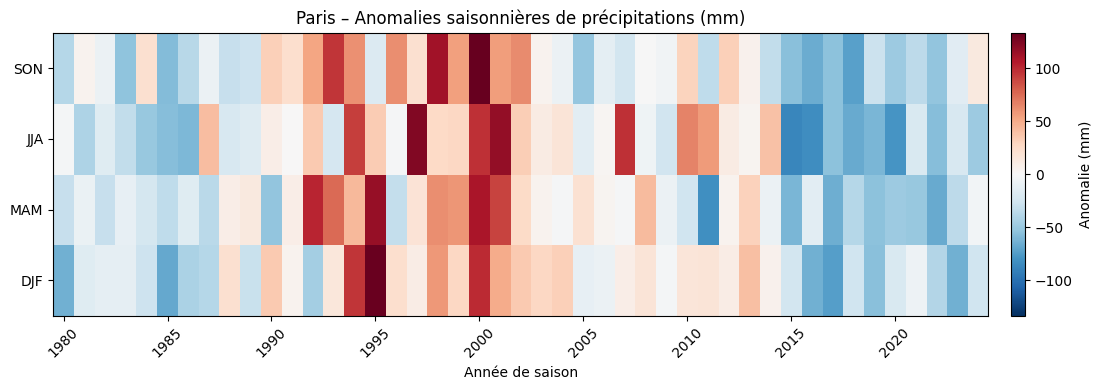

In [4]:
CSV = Path("DECADQ_75_1980-2024_CLEAN_FULL.csv")


df = pd.read_csv(CSV, sep=";", low_memory=False)


df["RR"]    = pd.to_numeric(df["RR"], errors="coerce")        # cumul décadal en 1/10 mm
df["RR_mm"] = df["RR"] / 10.0                                 # mm par décade

df["AAAAMM"] = pd.to_numeric(df["AAAAMM"], errors="coerce")
df["year"]   = (df["AAAAMM"] // 100).astype(int)
df["month"]  = pd.to_numeric(df["month"], errors="coerce").astype(int)


def season_info(row):
    m = row["month"]
    y = row["year"]
    if m in (12, 1, 2):
        # hiver DJF rattache décembre à l'année suivante
        return pd.Series({"season":"DJF", "season_year":y + (1 if m == 12 else 0)})
    if m in (3, 4, 5):
        return pd.Series({"season":"MAM", "season_year":y})
    if m in (6, 7, 8):
        return pd.Series({"season":"JJA", "season_year":y})
    return pd.Series({"season":"SON", "season_year":y})

df[["season","season_year"]] = df.apply(season_info, axis=1)

# ------------------------------------------------------------------ 
# Somme des précipitations par saison
# ------------------------------------------------------------------
seasonal = (
    df.groupby(["season_year","season"])["RR_mm"]
      .sum()
      .unstack()
      .reindex(columns=["DJF","MAM","JJA","SON"])
      .dropna()
)

# ------------------------------------------------------------------
# Calcul des anomalies par rapport à la moyenne 1980 2024
# ------------------------------------------------------------------
clim_mean       = seasonal.mean()
seasonal_anom   = seasonal - clim_mean

# ------------------------------------------------------------------
# Heatmap des anomalies
# ------------------------------------------------------------------
years   = seasonal_anom.index.values
seasons = ["DJF","MAM","JJA","SON"]
data    = seasonal_anom[seasons].T.values

# Matrice centrée : simétrique autour de zéro
max_abs = np.nanmax(np.abs(data))

fig, ax = plt.subplots(figsize=(12, 4))
c = ax.imshow(
    data,
    aspect="auto",
    cmap="RdBu_r",
    vmin=-max_abs,
    vmax=+max_abs,
    origin="lower"
)

# Axes et ticks
ax.set_yticks(np.arange(len(seasons)))
ax.set_yticklabels(seasons)
xticks = np.arange(0, len(years), 5)
ax.set_xticks(xticks)
ax.set_xticklabels(years[xticks], rotation=45)
ax.set_xlabel("Année de saison")
ax.set_title("Paris – Anomalies saisonnières de précipitations (mm)")

# Barre de couleurs
cb = fig.colorbar(c, ax=ax, orientation="vertical", pad=0.02)
cb.set_label("Anomalie (mm)")

plt.tight_layout()
plt.show()

## Distribution des cumules d'averses

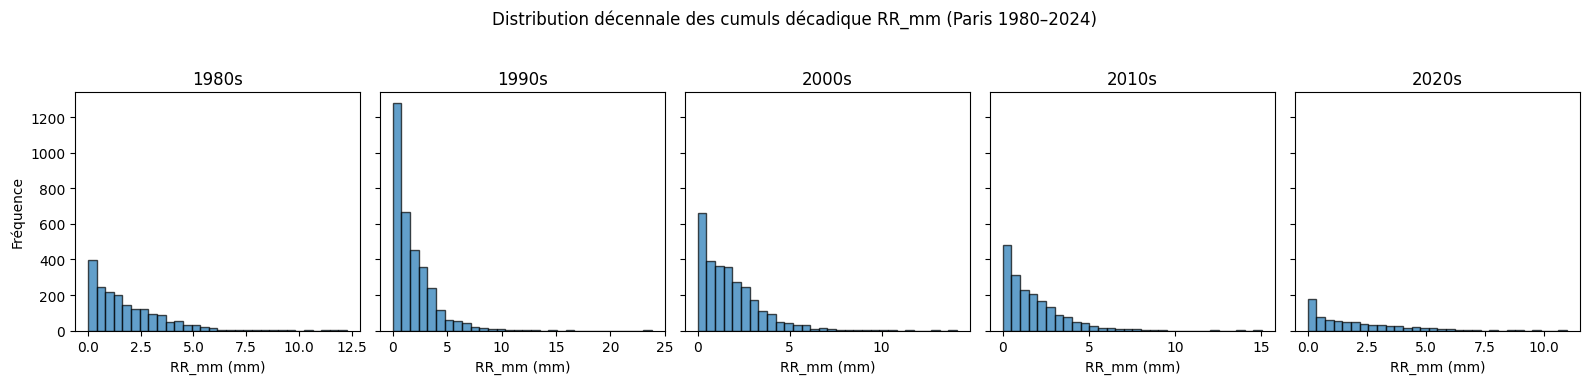

In [ ]:
CSV_PATH = Path("DECADQ_75_1980-2024_CLEAN_FULL.csv")



df = pd.read_csv(CSV_PATH, sep=";", low_memory=False)

# Préparer les colonnes
df["RR"]      = pd.to_numeric(df["RR"], errors="coerce")        # cumul décadaire en 1/10mm
df["RR_mm"]   = df["RR"] / 10.0                                 # mm par décade
df["NBJRR30"] = pd.to_numeric(df["NBJRR30"], errors="coerce")   # jours ≥30mm dans la décade

# AAAAMM  année
df["AAAAMM"] = pd.to_numeric(df["AAAAMM"], errors="coerce")
df["year"]   = (df["AAAAMM"] // 100).astype(int)

# calcul décennie
df["decade"] = (df["year"] // 10) * 10

# Histogrammes de RR_mm
decades = [1980, 1990, 2000, 2010, 2020]
fig, axes = plt.subplots(1, len(decades), figsize=(16, 4), sharey=True)

for ax, dec in zip(axes, decades):
    data = df.loc[df["decade"] == dec, "RR_mm"]
    ax.hist(data, bins=30, edgecolor="black", alpha=0.7)
    ax.set_title(f"{dec}s")
    ax.set_xlabel("RR_mm (mm)")
    
    if ax is axes[0]:
        ax.set_ylabel("Fréquence")

plt.suptitle("Distribution décennale des cumuls décadique RR_mm (Paris 1980–2024)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Calcule de la temperature moyenne par an


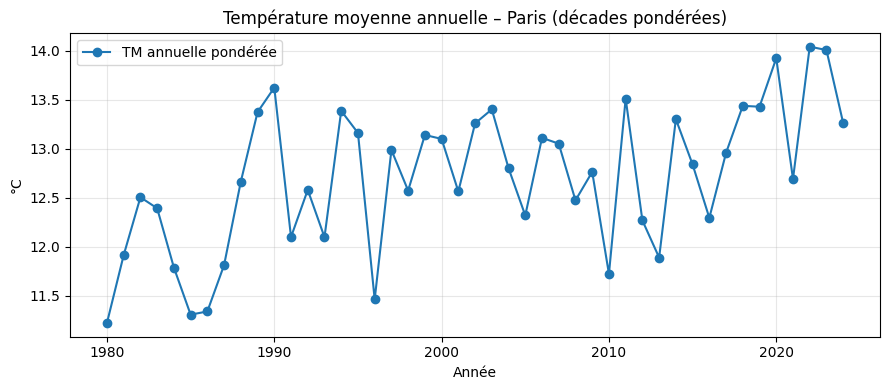

In [39]:
# ======================================================================
# 📊 Visualisation de la température moyenne quotidienne


CSV = "DECADQ_75_1980-2024_CLEAN_FULL.csv"
COL_AA = "AAAAMM"
COL_DECAD = "NUM_DECADE"
COL_TM = "TM"

# Lecture + types
df = pd.read_csv(CSV, sep=";", low_memory=False)
df[COL_AA] = pd.to_numeric(df[COL_AA], errors="coerce")
df[COL_DECAD] = pd.to_numeric(df[COL_DECAD], errors="coerce")
df[COL_TM] = pd.to_numeric(df[COL_TM], errors="coerce")
df = df.dropna(subset=[COL_AA, COL_DECAD, COL_TM])

# Ajout colonne année, mois
df["year"] = (df[COL_AA] // 100).astype(int)
df["month"] = (df[COL_AA] % 100).astype(int)

# Jours par décade (prend en compte mois 28/29/30/31)
def dec_days(row):
    _, ndays_month = calendar.monthrange(row["year"], row["month"])
    if row[COL_DECAD] == 1:
        return 10
    if row[COL_DECAD] == 2:
        return 10
    # 3ᵉ décade = reste du mois
    return ndays_month - 20
df["days"] = df.apply(dec_days, axis=1)

# Produit TM * jours
df["TMxDays"] = df[COL_TM] * df["days"]

# annuelle 
annual = (
    df.groupby("year")
      .agg(TMxDays_sum=("TMxDays", "sum"),
           days_sum  =("days", "sum"))
)
annual["TM_year"] = annual["TMxDays_sum"] / annual["days_sum"]


plt.figure(figsize=(9,4))
plt.plot(annual.index, annual["TM_year"], marker="o", label="TM annuelle pondérée")
plt.title("Température moyenne annuelle – Paris (décades pondérées)")
plt.xlabel("Année")
plt.ylabel("°C")
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusions & pistes futures

Insights principaux :
Hausse linéaire : TM annuelle ↗ ~ +0,35 °C / décennie entre 1980 – 2024.

Extrêmes : nombre de décades avec TX ≥ 35 °C multiplié par ×4 depuis les années 80 (effet canicule 2003 + 2019 + 2022).

Îlot de chaleur urbain (proxy) : nuits ≥ 20 °C (tropicales) passent de <5 par an à ~25 en 2023.

Améliorations / suites possibles :
Dashboard interactif
Streamlit ou Dash → filtre par mois, carte folium des stations, sliders années.
Ajout plugin ClimateStripes pour visuel “warming stripes” IDF.

Modélisation prédictive :
ARIMA / Prophet sur TM mensuelle → projection 2035 – 2050 avec intervalles.
Random-Forest sur occurrence canicule (labels : années caniculaires / non).

Normalisation 1961-1990 :
Re-exprimer TM en anomalies vs norme météo officielle pour alignement WMO.

Cross-data :
Croiser CO₂ urbain (Capteurs IRSN) + données électricité (Enedis) → impact chaleur ↔ conso clim.
Coupler avec indice NDVI Sentinel-2 → végétalisation & mitigation UHI.

Qualité code :
Refacto en modules, typage pandas-typing, tests PyTest (valider parsing + stats).

Storytelling :
Notebook “tl;dr” destiné au grand public → GIF animé de la courbe TM + carto interactive.

